In [1]:
#All files:
# 1) "C:\Users\Bradley\Videos\New folder\AgBH_cali_5m_13.5kev_2_1961.7s_RH661.032_x0.300_th0.000_5.00s_458795_waxs.tiff"
# 2) "C:\Users\Bradley\Videos\New folder\AgBH_cali_5m_13.5kev_6_2795.4s_RH-28.010_x0.300_th0.000_5.00s_458825_saxs.tiff"
# 3) "C:\Users\Bradley\Videos\New folder\AgBH_cali_5m_13.5kev_WAXSx-193_y22_x0.300_th0.000_5.00s_1000930_waxs.tiff"
# 4) "C:\Users\Bradley\Videos\New folder\AgBH_cali_5m_13.5kev_x0.000_y0.000_10.00s_988715_saxs.tiff"
# 5) "C:\Users\Bradley\Videos\New folder\AgBH_cali_5m_13.5kev_x0.000_y0.000_10.00s_988715_waxs.tiff"

In [35]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import math

In [95]:
img = Image.open(r"C:\Users\Bradley\Videos\New folder\AgBH_cali_5m_13.5kev_x0.000_y0.000_10.00s_988715_saxs.tiff")

img2 = np.asarray(Image.open("/Users/Bradley/Videos/New folder/AgBH_cali_5m_13.5kev_x0.000_y0.000_10.00s_988715_saxs.tiff"))
#For numpy version of file all backslashes are turned into forward slashes. Also no r C:

img.convert('I').show()

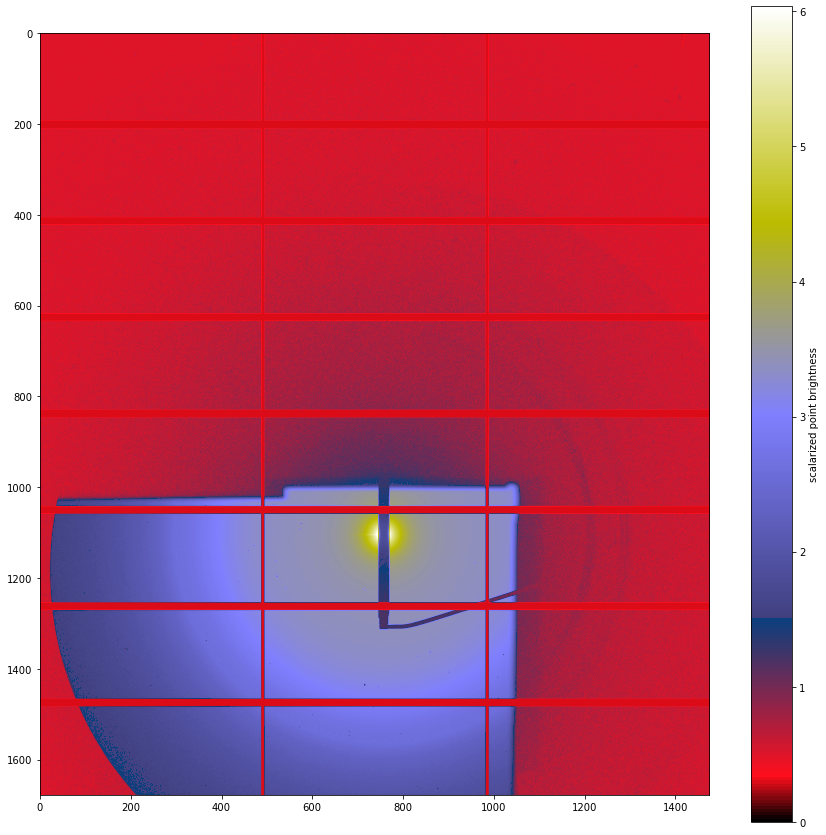

In [96]:
plt.figure(100, figsize=(15, 15))
plt.imshow(np.log10(img2+3), cmap="gist_stern")
cbar=plt.colorbar(label="scalarized point brightness")

In [97]:
#this method is just the distance formula. You input x and y which is one coordinate and then a and which is the second.
def euclidean_distance(x,y,a,b):
    d=((a-x)**2+(b-y)**2)**0.5
    return d


#this method takes an array and if values are close together it "combines them". 
#It groups values that are less than 10 apart and then finds the average of these clusters. This forms a smaller array, 
#which is then averaged one more time. This value is outputted. 
def cluster_avg(val_list):
    hold_avgs=np.array([])
    hold_indices=np.array([])
    lastindex=0
    for j in range(len(val_list)-1):#we don't want to go out of bounds. so keep the j+1 from going too far.
        if(val_list[j+1]>(val_list[j]+10)): #The +10 is just a number I have to be the amount above to split. So if values differ by 10, the array splits between these indices.
            for k in range(lastindex, (j+1)): #go from previous cluster's last index to the next one that starts a new cluster.
                hold_indices=np.append(hold_indices, val_list[k]) #put the cluster's indices in an array
            hold_avgs=np.append(hold_avgs, np.nanmean(hold_indices)) #put the mean of the cluster's indices in an array
            hold_indices=np.array([]) #empty the array that holds the indices
            lastindex=j+1 # move the last index up so we will not look at the same cluster again in our for loop
    
        elif(val_list[j+1]==val_list[-1]):
            for k in range(lastindex, (j+1)): #go from previous cluster's last index to the next one that starts a new cluster. This doesn't include the final array element
                hold_indices=np.append(hold_indices, val_list[k]) #put the cluster's indices in an array
            hold_indices=np.append(hold_indices, val_list[-1]) #include the final element of save
            hold_avgs=np.append(hold_avgs, np.nanmean(hold_indices)) #put the mean of the cluster's indices in an array
            hold_indices=np.array([]) #empty the array that holds the indices
            lastindex=j+1 # move the last index up so we will not look at the same cluster again in our for loop
    avg_of_clusters=np.nanmean(hold_avgs)  #the average of the clusters we got in the row or column above the threshold
    
    return(avg_of_clusters)


#you input a list and the mode of the list is found
def mode_finder(list_input):
    vals,counts = np.unique(list_input, return_counts=True)
    mode = np.argmax(counts)
    true_mode=vals[mode]
    
    return(true_mode)


#This array takes the maximum value in a row. It then multiplies this value by a threshold 
#(between 0 and 1 noninclusive) to get a lowerbound
#It goes through the array, finding the indicies corresponding to values above this lowerbound. These indicies are put into 
#another array. The method cluster_avg is used on this array. The cluster_avg output is put into a storing array.
#This whole process is repeated for each row. and each output is appended to the storing array. 
#This storing array is the output of this method.
def one_dim_search_rows(array_input,threshold_value):
    hold_avg=np.array([])
    holding_array=np.array([])
    for a in range(len(array_input)):
        valmax=np.amax(array_input[a]) #get the actual max value in the array
        lowerbound=threshold_value*valmax #we want to see where values above this are. The high intensity values. I chose a 15% threshold.
        for i in range(len(array_input[a])): #go through one row at a time
            if img2[a][i]>lowerbound:
                holding_array=np.append(holding_array,i) #get indices of higher values in an array
        
        hold_avg=np.append(hold_avg,cluster_avg(holding_array))
        holding_array=np.array([])
        
    return(hold_avg)


#This is the exact same as the method above, but for columns. It was easier to make separate methods because 
#rows in general are accesed with array[z] while columns are array[:,z]
def one_dim_search_cols(array_input,threshold_value):
    hold_avg=np.array([])
    holding_array=np.array([])
    for b in range(len(array_input[0])): #go through every column and note that img2[0] is the size of the number of columns.
        valmax=np.amax(array_input[:,b]) #get the actual max value in that column. 
        lowerbound=threshold_value*valmax #we want to see where values above this are. The high intensity values. I chose a 15% threshold.
        for j in range(len(img2[:,b])): #go through each index of the column
            if img2[:,b][j]>lowerbound: #if the element is larger than our bound
                holding_array=np.append(holding_array,j) #get the indicies of the larger elements and add them all to a list
                
        hold_avg=np.append(hold_avg,cluster_avg(holding_array))
        holding_array=np.array([])
                
    return(hold_avg)



# this method uses the distace formula to see which point is the farthest from a certain point.
#Two arrays are inputted. The first has x-coordinates and the second has y-coordinates. The same indices form a point. These
#points are compared to a third array, which is actually just length 2 (this array is just an x and y coordinate).
#which ever of the x and y coordinates are closest to the third array are the coordinates kept.
def closest_point_index(input_array1, input_array2,compare_point):
    hold_index=0
    lowest_dist=euclidean_distance(input_array1[0],input_array2[0],compare_point[0],compare_point[1])
    for i in range(len(input_array1)):
        c=euclidean_distance(input_array1[i],input_array2[i],compare_point[0],compare_point[1])
        if c<lowest_dist:
            hold_index=i
    return(hold_index)



#this method just removes the repeated indices from the x-coordinate and y-coordinate arrays, thus removing repeated points
def two_dim_remove_repeat(val_list_x,val_list_y): 
    result =[] 
    for i in val_list_x: 
        if i not in result: 
            result.append(i)
    
    result2=[]
    for i in val_list_y: 
        if i not in result2: 
            result2.append(i)

    return(result+result2)


def circle_point(main_array,center_x,center_y,radius,trig_f1,trig_f2): #this method creates the
    point_x=round(center_x+radius*trig_f1)
    point_y=round(center_y+radius*trig_f2)
    if(point_x>0 and point_y>0 and point_x<len(main_array) and point_y<len(main_array[0])):
        #the horizontal and vertical bounds seem to be switched because the first index in a 2D array tells you the row to 
        #access which is technically dealing with the vertical part of the image
        intensity=main_array[point_x][point_y]
        return(intensity)
    else:
        intensity=np.e
        return(intensity)


def helperloop(full_list): #see if enough of the points have stopped to end the run
    value=0
    for i in full_list: 
        if i==np.e:
            value+=1
    if (value==len(full_list)-1 or value==len(full_list)): #the second part is there if they somehow end reach index 0 together
        end_run=True
    else:
        end_run=False
        
    return(end_run)


def win_counter_help(intensity_array): #removes elements that are euler's number
    x=[value for value in intensity_array if value != np.e]
    return x

      
def one_dim_remove_repeat(val_list_x): #remove repeat elements
    result =[] 
    for i in val_list_x: 
        if i not in result: 
            result.append(i)
    return(result)


def quasicount(intensitylist,val): #count amount of times numbers 30 or under away from value appear
    occur_amount=0                 #it's like count method but counts element close instead of exactly same
    for i in intensitylist:
        if (i<val*1.2 and i>val*0.8):
            occur_amount+=1
    

def find_similar_count_and_scale(val_list_x):
    winquantity=0
    win_quantity_scale=np.empty([])
    val_list_x2=val_list_x
    holdlist=one_dim_remove_repeat(val_list_x) #remove repeat elements
    no_e_list=win_counter_help(val_list_x2) #remove euler's number
    for i in holdlist:
        win_quantity_scale=np.append(win_quantity_scale,quasicount(no_e_list,i)) 
        #take all unique elements and get the amount of times they each occur
    for j in win_quantity_scale: #if we just added the occurences we would get the length of the no_e_list array
        if(j!=None): #None can't be passed as a power. This was an issue that stopped the code
            winquantity+=1.01**j       #to scale each of these amounts up so that higher occurence numbers mean more, 
                                    #we do powers of 2
    return(winquantity)
        
        
def extend_unitcircle_outwards(center_x,center_y): 
    end_run=False
    win_counter=0
    radius=1 
    
    while(end_run==False):    
           
        #point 1 at 0 degrees
        keep1=circle_point(img2,center_x,center_y,radius,np.cos(0),np.sin(0))
        intensity1=keep1
        #point 2 at 30 degrees
        keep2=circle_point(img2,center_x,center_y,radius,np.cos(np.pi/6),np.sin(np.pi/6))
        intensity2=keep2
        #point 3 at 45 degrees
        keep3=circle_point(img2,center_x,center_y,radius,np.cos(np.pi/4),np.sin(np.pi/4))
        intensity3=keep3
        #point 4 at 60 degrees
        keep4=circle_point(img2,center_x,center_y,radius,np.cos(np.pi/3),np.sin(np.pi/3))
        intensity4=keep4 
        #point 5 at 90 degrees
        keep5=circle_point(img2,center_x,center_y,radius,np.cos(np.pi/2),np.sin(np.pi/2))
        intensity5=keep5
        #point 6 at 120 degrees
        keep6=circle_point(img2,center_x,center_y,radius,-np.cos(np.pi/3),np.sin(np.pi/3))
        intensity6=keep6
        #point 7 at 135 degrees
        keep7=circle_point(img2,center_x,center_y,radius,-np.cos(np.pi/4),np.sin(np.pi/4))
        intensity7=keep7
        #point 8 at 150 degrees
        keep8=circle_point(img2,center_x,center_y,radius,-np.cos(np.pi/6),np.sin(np.pi/6))
        intensity8=keep8
        #point 9 at 180 degrees
        keep9=circle_point(img2,center_x,center_y,radius,-np.cos(0),np.sin(0))
        intensity9=keep9
        #point 10 at 210 degrees
        keep10=circle_point(img2,center_x,center_y,radius,-np.cos(np.pi/6),-np.sin(np.pi/6))
        intensity10=keep10   
        #point 11 at 225 degrees
        keep11=circle_point(img2,center_x,center_y,radius,-np.cos(np.pi/4),-np.sin(np.pi/4))
        intensity11=keep11
        #point 12 at 240 degrees
        keep12=circle_point(img2,center_x,center_y,radius,-np.cos(np.pi/3),-np.sin(np.pi/3))
        intensity12=keep12   
        #point 13 at 270 degrees
        keep13=circle_point(img2,center_x,center_y,radius,-np.cos(np.pi/2),-np.sin(np.pi/2))
        intensity13=keep13   
        #point 14 at 300 degrees
        keep14=circle_point(img2,center_x,center_y,radius,np.cos(np.pi/3),-np.sin(np.pi/3))
        intensity14=keep14
        #point 15 at 315 degrees
        keep15=circle_point(img2,center_x,center_y,radius,np.cos(np.pi/4),-np.sin(np.pi/4))
        intensity15=keep15  
        #point 16 at 330 degrees
        keep16=circle_point(img2,center_x,center_y,radius,np.cos(np.pi/6),-np.sin(np.pi/6))
        intensity16=keep16
            
        
        hold_intensities=np.array([intensity1,intensity2,intensity3,intensity4,intensity5,intensity6,intensity7,intensity8,intensity9,intensity10,intensity11,intensity12,intensity13,intensity14,intensity15,intensity16])
        all_end=np.array([intensity1,intensity2,intensity3,intensity4,intensity5,intensity6,intensity7,intensity8,intensity9,intensity10,intensity11,intensity12,intensity13,intensity14,intensity15,intensity16])
        win_counter+=find_similar_count_and_scale(hold_intensities)
        
        #we want to know if 15 of the 16 (or 16 out of 16) points are done running. If so, the method is finished.
        end_run=helperloop(all_end)

        radius+=10
    
    return win_counter



C:\Users\Bradley\AppData\Local\Temp/ipykernel_36348/2478796076.py:29: RuntimeWarning: Mean of empty slice
  avg_of_clusters=np.nanmean(hold_avgs)  #the average of the clusters we got in the row or column above the threshold


20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1

Possible center: [741.0,1105.0]
Possible center: [742.5,1104.5]
Possible center: [756.0,1183.1666666666667]
Possible center: [755.75,1186.8333333333333]
Possible center: [1087.0,1285.0]


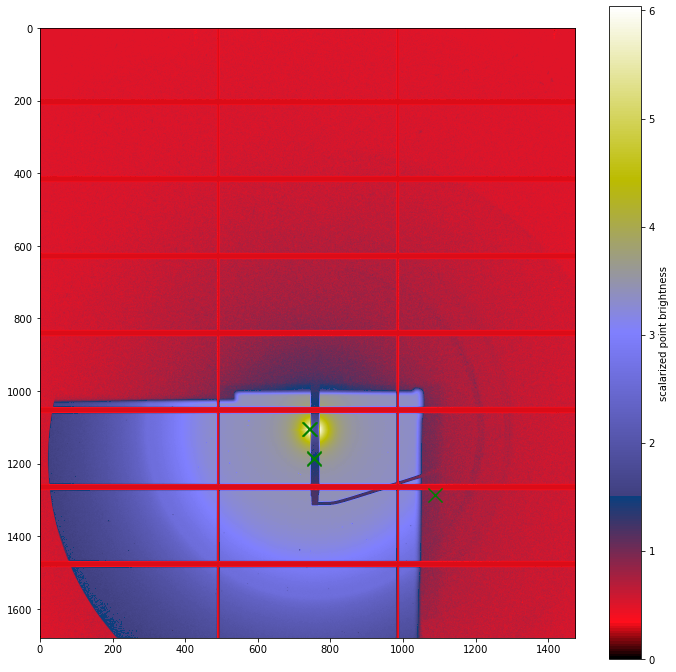

In [98]:
#plot to show all possible centers (if the same center was predicted multiple times, one is removed). So repeats are removed.
plt.figure(100, figsize=(12, 12))
plt.imshow(np.log10(img2+3), cmap="gist_stern")
cbar=plt.colorbar(label="scalarized point brightness")



threshold=0.999
count=20
saved_point_x=np.array([])
saved_point_y=np.array([])

while(threshold>0):
    keep_mode=np.array([])
    keep_mode=np.append(keep_mode, mode_finder(one_dim_search_rows(img2,threshold)))
    keep_mode=np.append(keep_mode, mode_finder(one_dim_search_cols(img2,threshold)))
    
    
    saved_point_x=np.append(saved_point_x,keep_mode[0])
    saved_point_y=np.append(saved_point_y,keep_mode[1])
    
    
    threshold-=0.05
    print(count)
    count-=1
    

    

lasthold=np.array_split(two_dim_remove_repeat(saved_point_x,saved_point_y),2)    
#for case 1 the second array has 1 more element

print()
for i in range(len(lasthold[0])-1):
    print("Possible center: ["+str(lasthold[0][i])+","+str(lasthold[1][i])+"]")
    plt.scatter(lasthold[0][i], lasthold[1][i], marker="x", s=200, c="green")
    



Center [1087.0,1285.0]


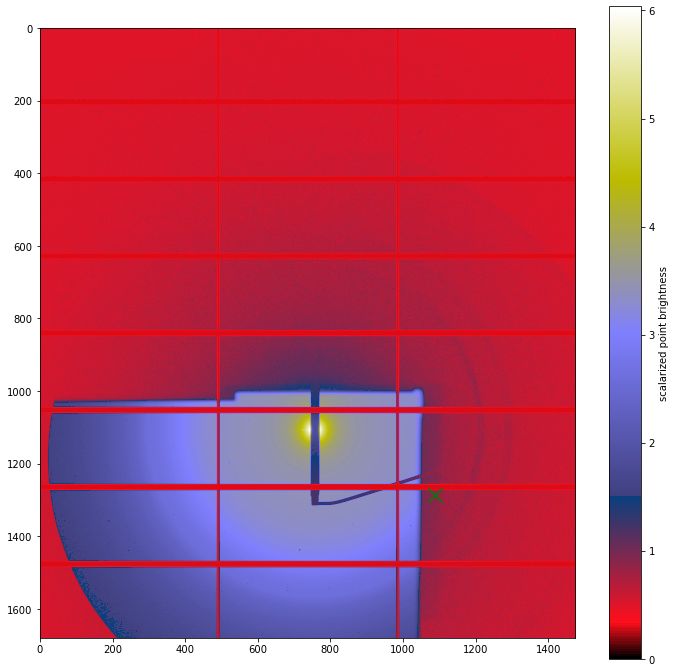

In [99]:
plt.figure(100, figsize=(12, 12))
plt.imshow(np.log10(img2+3), cmap="gist_stern")
cbar=plt.colorbar(label="scalarized point brightness")
keep_score=np.array([])
for i in range(len(lasthold[0])-1):
    keep_score=np.append(keep_score,extend_unitcircle_outwards(lasthold[0][i],lasthold[1][i]))


plt.scatter(lasthold[0][np.argmax(keep_score)], lasthold[1][np.argmax(keep_score)], marker="x", s=200, c="green")
print("Center ["+str(lasthold[0][np.argmax(keep_score)])+","+str(lasthold[1][np.argmax(keep_score)])+"]")